In [1]:
# import necessary libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco
import seaborn as sns
from datetime import datetime, timedelta


In [113]:
# Global cache to store downloaded stock data
stock_data_cache = {}

def sp500_stocks(start_date = None, end_date = None):
    try:
      if 'sp500' in stock_data_cache:  # Check cache first
          return stock_data_cache['sp500']

      sp500_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
      sp500_tickers = sp500_table['Symbol'].tolist()

      print('downloaded sp500 tickers')
      
      # Initialize volatilities dictionary and populate it in one go
      volatilities = {}

      # Use current date if end_date is not provided
      if end_date is None:
          end_date = datetime.now().strftime('%Y-%m-%d')

      # if start_date is not provided, use 5 year before end_date
      if start_date is None:
        start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')

      print('downloading sp500 data')
      # download sp500 data
      sp500_data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']
            
      for ticker in sp500_tickers:
        try:
            ticker_obj = yf.Ticker(ticker)
            market_cap = ticker_obj.info.get('marketCap', 0)
            if market_cap < 3e9:  # Skip if market cap is less than 3 billion
                continue

            beta = ticker_obj.info.get('beta', None)
            if beta is None:  # Skip if beta is not available
                continue

        except Exception:
            continue  # Skip to the next ticker if any exception occurs
        
        volatilities[ticker] = beta  # Add beta to volatilities only if no exception occurred and market cap is >= 3 billion
      
      sorted_volatilities = {k: v for k, v in sorted(volatilities.items(), key=lambda item: abs(1 - item[1]))}
      vol_ticker = [ticker for ticker in reversed(sorted_volatilities.keys())]
      
      stock_data_cache['sp500'] = vol_ticker  # Cache the result
      return vol_ticker
    
    except Exception as e:
        print(f"An unknown error occurred: {e}")

    return []

sp500_stocks = sp500_stocks()

downloaded sp500 tickers
downloading sp500 data
[*********************100%***********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-10-24 -> 2023-10-23)')


In [3]:
# 2. Valuate Stock using DCF
# Pre-fetch treasury yield and market data
treasury_ticker = yf.Ticker('^TNX')
market_ticker = yf.Ticker('^GSPC')
risk_free_rate = treasury_ticker.history(period='max')['Close'].iloc[-1] / 100
market_history = market_ticker.history(period='max')['Close']


def fetch_stock_data(ticker):
    try:
        if ticker in stock_data_cache:
            return stock_data_cache[ticker]

        stock = yf.Ticker(ticker)
        info = stock.info
        financials = stock.financials
        income_statement = stock.income_stmt
        balance_sheet = stock.balance_sheet
        cash_flow = stock.cash_flow
        dividends = stock.dividends

        stock_data_cache[ticker] = (info, financials, income_statement, 
                                    balance_sheet, cash_flow, dividends)
        
        return info, financials, income_statement, balance_sheet, cash_flow, dividends
    
    except yf.YFinanceError as yf_err:
        print(f"Yahoo Finance Error for {ticker}: {yf_err}")
    except Exception as e:
        print(f"An unknown error occurred for {ticker}: {e}")
        
    return None, None, None, None, None, None


# Function to calculate discount rate


def discount_rate(stock_data):
    info, financials, _, balance_sheet, _, _ = stock_data
    E = info['marketCap']
    D = balance_sheet.loc['Total Debt'].iloc[-1]
    V = E + D
    Tc = 0.21

    Interest_Expense = financials.loc['Interest Expense'].iloc[0]
    Rd = Interest_Expense / D * (1 - Tc)

    Re = cost_of_equity(stock_data)

    return (E/V) * Re + (D/V) * Rd * (1-Tc)

# Function to calculate cost of equity


def cost_of_equity(stock_data):
    info, _, _, _, _, _ = stock_data
    Beta = info['beta']

    last_date = market_history.index[-1]
    start_date = last_date - pd.DateOffset(years=5)
    filtered_data = market_history[start_date:last_date]
    daily_change = filtered_data.pct_change().dropna()
    annualized_return = ((1 + daily_change.mean()) ** 252 - 1)

    return risk_free_rate + Beta * (annualized_return - risk_free_rate)

# Function to get Free Cash Flow


def get_FCF(stock_data):
    _, financials, _, _, cash_flow, _ = stock_data
    CFO = cash_flow.loc['Operating Cash Flow'].iloc[0]
    IE = financials.loc['Interest Expense'].iloc[0]
    CAPEX = cash_flow.loc['Capital Expenditure'].iloc[0]
    return CFO + IE * (1 - 0.21) - CAPEX

# Function to calculate Terminal Value


def Terminal_Value(stock_data):
    info, _, income_statement, balance_sheet, _, dividends = stock_data
    FCFF = get_FCF(stock_data)
    dividend_paid = dividends.iloc[-1] if not dividends.empty else 0
    net_income = income_statement.loc['Net Income'].iloc[0]
    retention_rate = 1 - dividend_paid / net_income

    debt = balance_sheet.loc['Total Debt'].iloc[0]
    equity = info['marketCap']
    ROIC = (net_income - dividend_paid) / (debt + equity)

    g = retention_rate * ROIC
    r = discount_rate(stock_data)

    return FCFF * (1 + g) / (r - g)

# Main DCF function
def DCF(ticker, forecast_period=5):
    stock_data = fetch_stock_data(ticker)
    WACC = discount_rate(stock_data)
    FCFFn = get_FCF(stock_data)
    TV = Terminal_Value(stock_data)
    PV_TV = TV / (1 + WACC) ** forecast_period

    PV_FCFF = sum(FCFFn / (1 + WACC) **
                  i for i in range(1, forecast_period + 1))

    EV = PV_TV + PV_FCFF
    info = stock_data[0]
    Implied_Share_Price = EV / info['sharesOutstanding']
    return Implied_Share_Price

In [4]:
# 3. Valuator
# Function to valuate trade 
def valuator(stock: str, end_date: str = None):
    # Use current date if end_date is not provided
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    # if stock is not a valid ticker, return False
    if not yf.Ticker(stock).info:
        print('Invalid stock ticker. Try Again!')

    # Calculate valuated price using DCF method
    valuated_price = DCF(stock)
    if valuated_price is None:
        print('DCF calculation cannot be done.')

    # Download stock's adjusted close price
    try:
        current_price = yf.download(
            stock, start='2015-01-01', end=end_date)['Adj Close'].iloc[-1]
    except Exception as e:
        print(f"Failed to download stock data: {e}")
        return None  # Return None or some default value to handle this in the calling function


    # Truncate prices to the second decimal place
    truncated_current_price = np.trunc(current_price * 100) / 100
    truncated_valuated_price = np.trunc(valuated_price * 100) / 100

    # return a dictionary with the current price, valuated price, and valuation
    if truncated_current_price > truncated_valuated_price:
        return {"current_price": truncated_current_price, "valuated_price": truncated_valuated_price, "valuation": "overvalued"}
    elif truncated_current_price < truncated_valuated_price:
        return {"current_price": truncated_current_price, "valuated_price": truncated_valuated_price, "valuation": "undervalued"}
    else:
        return {"current_price": truncated_current_price, "valuated_price": truncated_valuated_price, "valuation": "fairly valued"}
    
# valuate the list of tickers in tickers and make it into a data frame with columns titled "current price", "valuated price", and "valuation"
def valuate(tickers: list, end_date: str = None):
    valuations = []
    for ticker in tickers:
        try:
          valuation = valuator(ticker, end_date)
        except Exception as e:
          print(f"Failed to valuate {ticker}: {e}")
          continue
        if valuation:
            valuations.append([ticker, valuation['current_price'], valuation['valuated_price'], valuation['valuation']])
    
    df = pd.DataFrame(valuations, columns=["Ticker", "Current Price", "Valuated Price", "Valuation"])
    df.set_index("Ticker", inplace=True)

    # Filter the DataFrame to include only undervalued stocks
    undervalued_df = df[df["Valuation"] == "undervalued"].copy()
    
    # Calculate the percentage difference between valuated price and current price
    undervalued_df["Percentage Difference"] = ((undervalued_df["Valuated Price"] - undervalued_df["Current Price"]) / undervalued_df["Current Price"]) * 100
    
    # Sort the DataFrame by the percentage difference in descending order
    undervalued_df.sort_values("Percentage Difference", ascending=False, inplace=True)
    
    return undervalued_df

valuated_result = valuate(sp500_stocks)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
valuated_result

,Current Price,Valuated Price,Valuation,Percentage Difference
Ticker,,,,
TFC,27.15,10988.97,undervalued,40375.027624
VTRS,9.30,552.24,undervalued,5838.064516
LYB,92.05,5443.21,undervalued,5813.318848
MRO,28.48,1235.42,undervalued,4237.851124
DOW,48.99,1779.72,undervalued,3532.823025
...,...,...,...,...
PYPL,53.38,56.25,undervalued,5.376546
ORLY,907.05,939.32,undervalued,3.557687
EBAY,40.75,41.63,undervalued,2.159509


In [62]:
# find top 50 valuated stocks in order of market capitalization
tickers = valuated_result.index.tolist()
# Use current date if end_date is not provided
end_date = datetime.now().strftime('%Y-%m-%d')

# if start_date is not provided, use 5 year before end_date
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
data = yf.download(tickers, start_date, end_date)
list = []
for ticker in tickers: 
    ticker_obj = yf.Ticker(ticker)
    market_cap = ticker_obj.info.get('marketCap', 0)
    list.append([ticker, market_cap])

market_cap_df = pd.DataFrame(list, columns=["Ticker", "Market Cap"])

[*********************100%***********************]  237 of 237 completed


In [108]:
# cut the valuated_result to the top 50 market cap stocks
valuated_result = valuated_result.loc[market_cap_df.sort_values("Market Cap", ascending=False).head(50).index]
display(valuated_result)
valuated_result.to_csv("valuated_result.csv")

,Current Price,Valuated Price,Valuation,Percentage Difference
Ticker,,,,
GOOG,136.74,226.26,undervalued,65.467310
GOOGL,135.60,221.22,undervalued,63.141593
UNH,527.03,574.45,undervalued,8.997590
WMT,158.75,315.23,undervalued,98.570079
JNJ,153.00,242.26,undervalued,58.339869
PG,148.05,211.70,undervalued,42.992232
CVX,166.83,2424.30,undervalued,1353.155907
HD,286.41,314.16,undervalued,9.688908
ORCL,101.84,124.86,undervalued,22.604085


In [110]:
# pick top 30 stocks
top_30 = valuated_result.index.tolist()[:30]

In [85]:
# 5. Allocator
def max_sharpe_portfolio(tickers, end_date=None, num_simulations=200000):
        # Fetch historical data
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=10*365)).strftime('%Y-%m-%d')
    historical_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Calculate daily returns
    daily_returns = historical_data.pct_change().dropna()
    
    # Set up an array to hold the simulation results
    results = np.zeros((3 + len(tickers), num_simulations))
    
    for i in range(num_simulations):
        # Randomize portfolio weights
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        
        # Calculate portfolio return and standard deviation
        port_return = np.sum(daily_returns.mean() * weights) * 252
        port_std_dev = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))
        
        # Calculate Sharpe ratio assuming 0% risk-free rate
        sharpe_ratio = port_return / port_std_dev
        
        # Store the results
        results[0,i] = port_return
        results[1,i] = port_std_dev
        results[2,i] = sharpe_ratio
        for j in range(len(weights)):
            results[j+3,i] = weights[j]
            
    # Convert results array to Pandas DataFrame
    columns = ['Return', 'Risk', 'Sharpe'] + [ticker for ticker in tickers]
    results_df = pd.DataFrame(results.T, columns=columns)
    
    # Locate the portfolio with the max Sharpe ratio
    max_sharpe_port = results_df.iloc[results_df['Sharpe'].idxmax()]
    
    return max_sharpe_port


In [86]:
allocation = max_sharpe_portfolio(top_30)

[*********************100%***********************]  30 of 30 completed


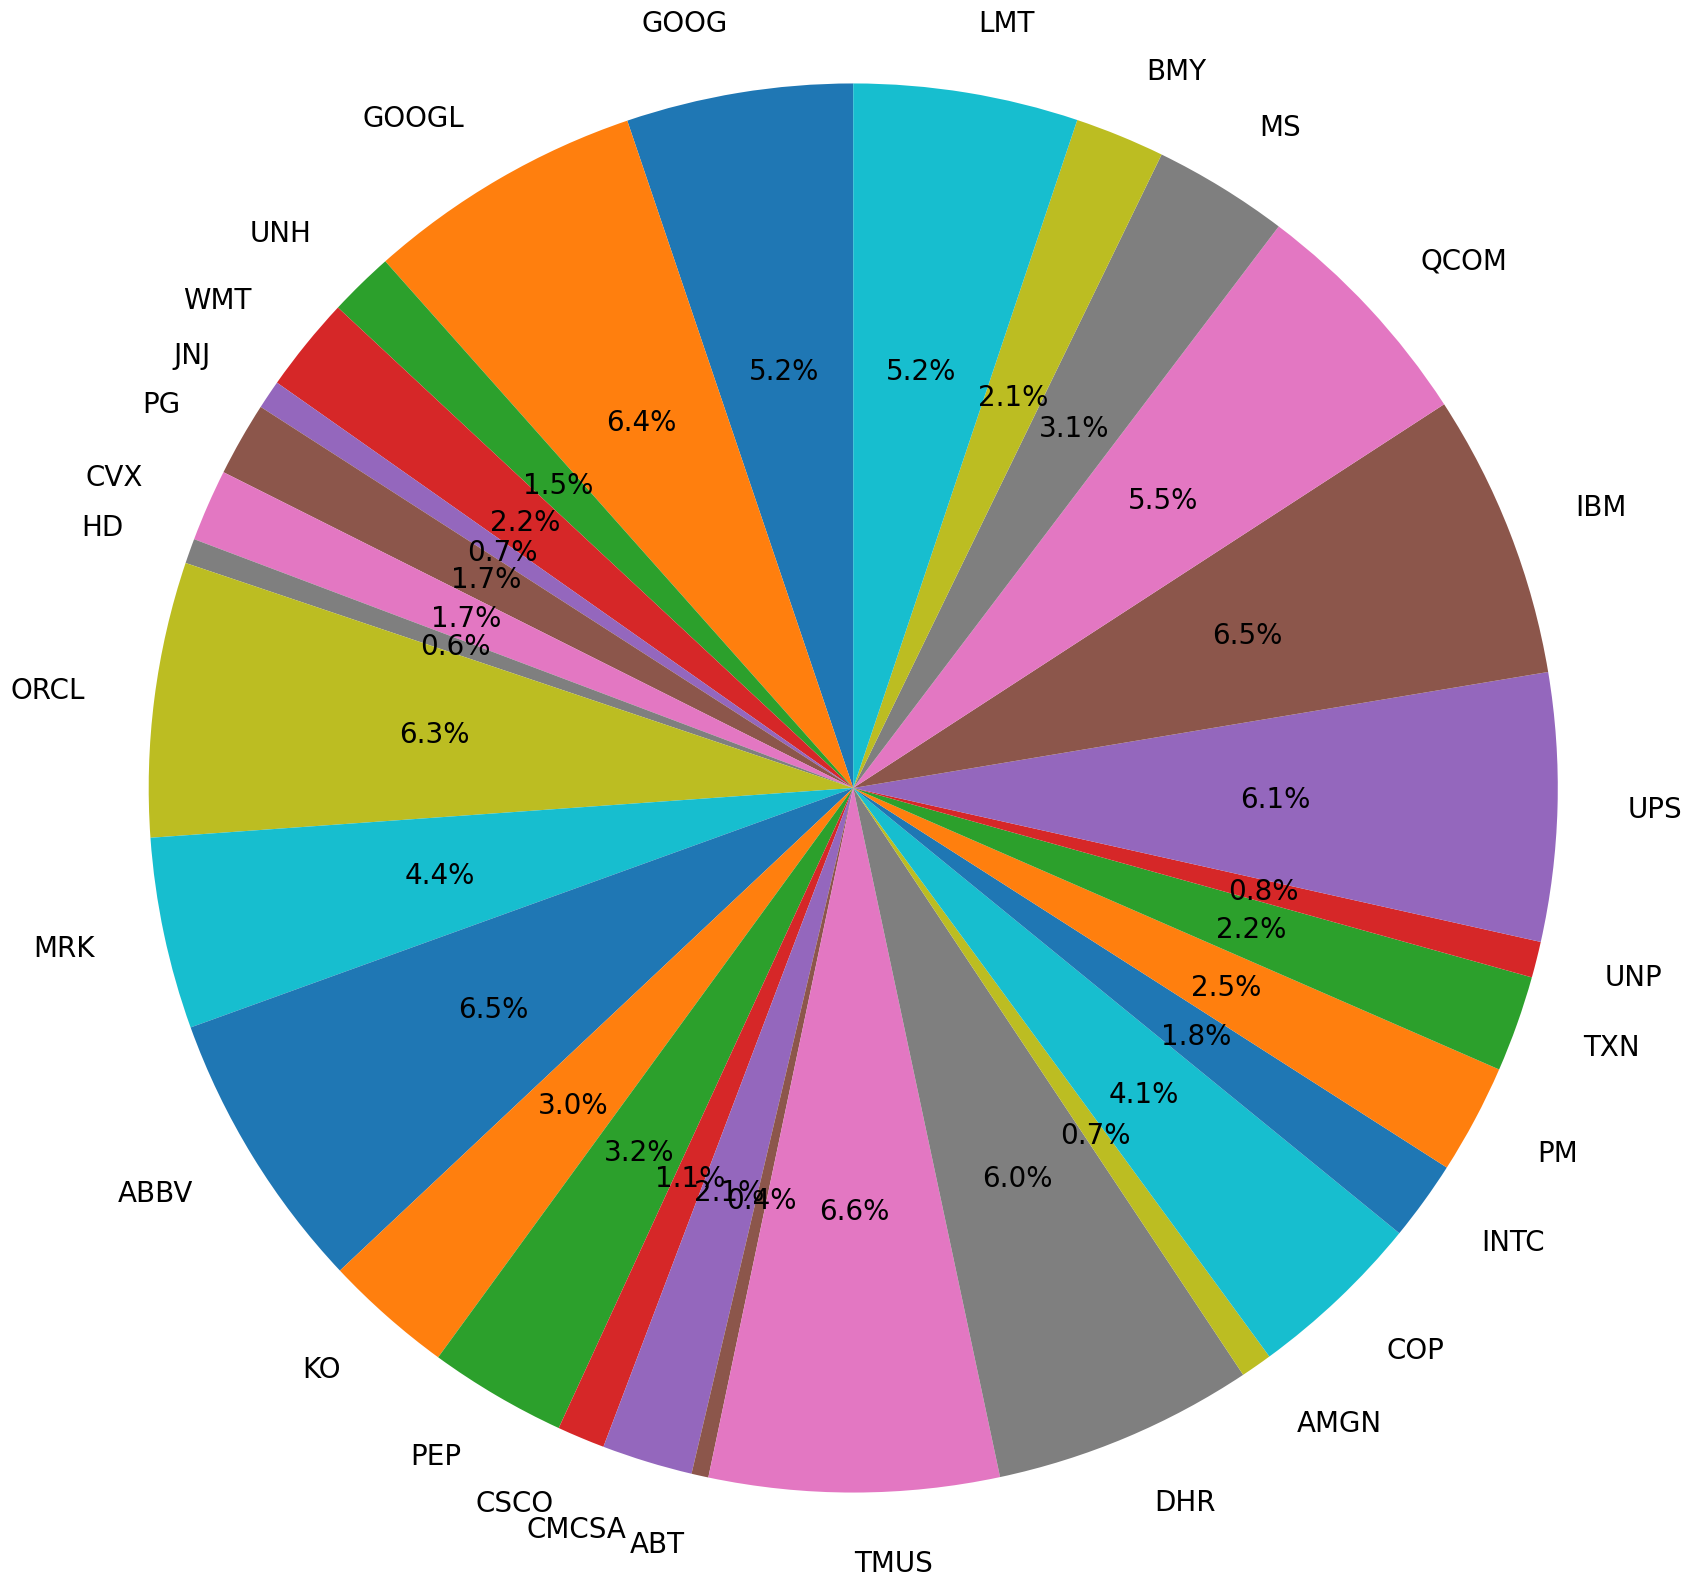

In [98]:
# change allocation to a pie chart
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = allocation.index[3:]
sizes = allocation[3:]

fig1, ax1 = plt.subplots()

ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# increase size of pie chart
fig1.set_size_inches(20, 20)
# increase font size
plt.rcParams.update({'font.size': 10})
plt.show()


[*********************100%***********************]  30 of 30 completed
**** Correlation Matrix ****


,ABBV,ABT,AMGN,BMY,CMCSA,COP,CSCO,CVX,DHR,GOOG,...,PEP,PG,PM,QCOM,TMUS,TXN,UNH,UNP,UPS,WMT
ABBV,1.000000,0.669133,0.820160,0.883591,0.091999,0.863119,0.494140,0.860893,0.778055,0.741227,...,0.936942,0.858530,0.909936,0.676394,0.849637,0.790963,0.970698,0.791597,0.805329,0.787400
ABT,0.669133,1.000000,0.628015,0.690150,0.653759,0.332982,0.550651,0.327805,0.941670,0.888913,...,0.695421,0.855660,0.728483,0.941541,0.806855,0.924930,0.742088,0.900097,0.904776,0.812302
AMGN,0.820160,0.628015,1.000000,0.860432,0.164486,0.619973,0.246312,0.611566,0.691359,0.600609,...,0.772800,0.786030,0.713134,0.604562,0.846031,0.708854,0.805967,0.664438,0.678699,0.808873
BMY,0.883591,0.690150,0.860432,1.000000,0.116146,0.662212,0.242316,0.680474,0.769715,0.647933,...,0.833912,0.804605,0.813259,0.692552,0.860029,0.763658,0.882894,0.734054,0.766284,0.733759
CMCSA,0.091999,0.653759,0.164486,0.116146,1.000000,-0.176048,0.532458,-0.185624,0.533613,0.636459,...,0.149485,0.404613,0.310139,0.596052,0.374285,0.582095,0.165120,0.541589,0.516490,0.452471
COP,0.863119,0.332982,0.619973,0.662212,-0.176048,1.000000,0.480584,0.981086,0.498978,0.507074,...,0.826699,0.618800,0.801981,0.343066,0.583011,0.535702,0.829408,0.561489,0.545714,0.533235
CSCO,0.494140,0.550651,0.246312,0.242316,0.532458,0.480584,1.000000,0.467248,0.577465,0.719601,...,0.543538,0.550459,0.652343,0.492109,0.403192,0.617790,0.521856,0.651939,0.575906,0.494496
CVX,0.860893,0.327805,0.611566,0.680474,-0.185624,0.981086,0.467248,1.000000,0.474922,0.469494,...,0.824420,0.622433,0.794629,0.337925,0.575531,0.526424,0.814011,0.558073,0.535550,0.515627
DHR,0.778055,0.941670,0.691359,0.769715,0.533613,0.498978,0.577465,0.474922,1.000000,0.921486,...,0.796822,0.885603,0.818192,0.918177,0.874764,0.949963,0.856100,0.913133,0.939422,0.837027
GOOG,0.741227,0.888913,0.600609,0.647933,0.636459,0.507074,0.719601,0.469494,0.921486,1.000000,...,0.754122,0.844416,0.816580,0.858455,0.776945,0.910372,0.812712,0.906581,0.896488,0.804012


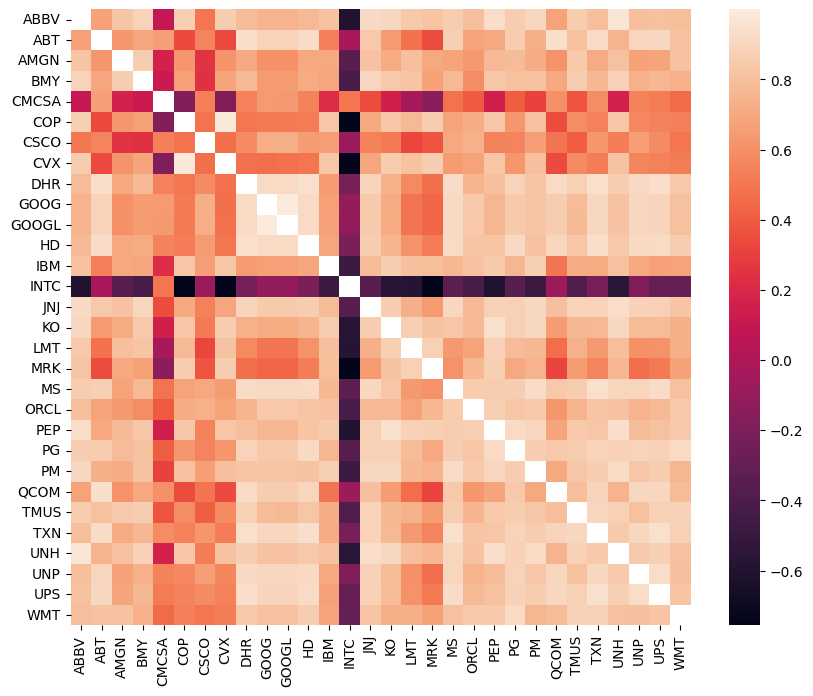

The pair with the highest correlation is ('GOOG', 'GOOGL') with correlation of 1.0
The pair with the lowest correlation is ('COP', 'INTC') with correlation of -0.76


In [112]:
# make seaborn heatmap of correlation matrix of top 30 stocks
data = yf.download(top_30, start_date, end_date)['Adj Close']
# Compute and display the correlation matrix
corr_matrix = data.corr()
print('**** Correlation Matrix ****')
display(corr_matrix)

#Removing Diagonal Elements which are always 1 
corr_matrix[corr_matrix==1] = None

# Find the assets with the highest and lowest correlation
highest_corr_pair = corr_matrix.unstack().idxmax()
lowest_corr_pair = corr_matrix.unstack().idxmin()

#Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix)
plt.show()

print(f"The pair with the highest correlation is {highest_corr_pair} with correlation of {corr_matrix.unstack()[highest_corr_pair].round(2)}")
print(f"The pair with the lowest correlation is {lowest_corr_pair} with correlation of {corr_matrix.unstack()[lowest_corr_pair].round(2)}")